In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from cvxopt import matrix, solvers


In [32]:
df = pd.read_csv('IDEA.csv')
df = df['close']
df_original = df.copy()
scaler = StandardScaler()
df = scaler.fit_transform(df.values.reshape(-1, 1))
df = df.flatten()

In [40]:
def get_data(df, t):
    n = len(df)
    X = np.zeros((n-t, t))
    for i in range(n-t):
        X[i] = df[i:i+t]
    Y = df[t:]
    l = len(X)
    split = int(0.8*l)
    X_train = X[:split]
    X_test = X[split:]
    Y_train = Y[:split]
    Y_test = Y[split:]
    return X_train, X_test, Y_train, Y_test

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_linear_svr(X_train, Y_train, X_test, Y_test, w, b, t, df_original, scaler):
    """
    Plots the SVR predictions, actual closing price, and the previous t-day average in the original scale.
    Y-axis starts from 0.
    
    Parameters:
    - X_train, Y_train: Scaled training data
    - X_test, Y_test: Scaled test data
    - w, b: SVR model parameters
    - t: Window size for the previous t-day average
    - df_original: Original unscaled dataframe (for closing prices)
    - scaler: The StandardScaler used to scale only the Y labels (closing prices)
    """

    # Predictions on the test set (no inverse scaling needed)
    Y_pred_scaled = X_test @ w + b
    
    # Inverse transform Y_test only
    # var = np.var(df_original)
    # m = np.mean(df_original)
    # Y_test_original = Y_test * var + m
    Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

    # Use the true range of the original closing prices for the predicted values
    Y_pred_scaled = -Y_pred_scaled  
    Y_min, Y_max = df_original.min(), df_original.max()
    Y_pred = Y_min + (Y_pred_scaled - Y_pred_scaled.min()) * (Y_max - Y_min) / (Y_pred_scaled.max() - Y_pred_scaled.min())

    # Previous t-day average using original data
    prev_avg = []
    train_end = len(Y_train)

    for i in range(len(Y_test)):
        avg_window_start = max(0, train_end - t + i)
        avg_window_end = train_end + i
        prev_avg.append(np.mean(df_original[avg_window_start:avg_window_end]))

    prev_avg = np.array(prev_avg)

    # Plotting
    plt.figure(figsize=(14, 6))
    
    plt.plot(Y_test_original, label='Actual Closing Price', color='blue', linewidth=0.7)
    plt.plot(Y_pred, label='Predicted Closing Price', color='green', linestyle='--', linewidth=1)
    plt.plot(prev_avg, label=f'Previous {t}-Day Average', color='orange', linestyle='-.', linewidth=1.5)
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Price')
    plt.title(f'linear SVR Prediction vs Actual vs Previous {t}-Day Average')
    
    plt.ylim(0, max(np.max(Y_test_original), np.max(Y_pred), np.max(prev_avg)) * 1.05)

    plt.legend()
    plt.grid(True)
    plt.show()


In [35]:


def linear_svr(X, Y):
    # Parameters
    C = 1.0  # Regularization parameter
    epsilon = 0.1
    n, t = X.shape

    # Prepare the dual problem
    # Kernel matrix for linear SVR (X @ X.T)
    K = X @ X.T

    # Formulating the quadratic programming problem
    P = np.block([
        [K, -K],
        [-K, K]
    ])

    q = np.hstack([epsilon + Y, epsilon - Y])

    G = np.vstack([
        np.eye(2 * n),
        -np.eye(2 * n)
    ])

    h = np.hstack([C * np.ones(2 * n), np.zeros(2 * n)])

    A = np.hstack([np.ones(n), -np.ones(n)]).reshape(1, -1)
    b = np.array([0.0])

    # Convert to cvxopt format
    P = matrix(P)
    q = matrix(q)
    G = matrix(G)
    h = matrix(h)
    A = matrix(A)
    b = matrix(b)

    solvers.options['show_progress'] = False
    # Solve the quadratic program
    sol = solvers.qp(P, q, G, h, A, b)

    # Extract the dual variables
    alpha = np.array(sol['x']).flatten()[:n]
    alpha_star = np.array(sol['x']).flatten()[n:]

    # Compute the weights and bias
    w = np.sum((alpha - alpha_star).reshape(-1, 1) * X, axis=0)
    b = np.mean(Y - X @ w)

    # print("Weights:", w)
    # print("Bias:", b)

    return w, b


In [36]:
import numpy as np
import cvxopt

def kernel_rbf(x1, x2, gamma):
    """ RBF Kernel function """
    sq_dist = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
    return np.exp(-gamma * sq_dist)

def kernel_svr_dual(X_train, Y_train, gamma, C=1.0, epsilon=0.1):
    """
    Solves the dual form of the Kernelized SVR with RBF kernel using cvxopt.

    Parameters:
    - X_train: Training features (n x t)
    - Y_train: Training targets (n,)
    - gamma: RBF kernel parameter
    - C: Regularization parameter
    - epsilon: Epsilon-tube width

    Returns:
    - alpha: Lagrange multipliers for the positive SVs
    - alpha_star: Lagrange multipliers for the negative SVs
    - w: Weight vector (computed from support vectors)
    - b: Bias term
    """
    n = len(Y_train)

    # Kernel matrix K(i, j) = exp(-gamma * ||x_i - x_j||^2)
    K = kernel_rbf(X_train, X_train, gamma)

    # Build the matrices for cvxopt
    P = np.block([[K, -K], [-K, K]])  # Kernel matrix for both alpha and alpha*
    q = np.hstack([epsilon + Y_train, epsilon - Y_train])

    G = np.vstack([
        np.eye(2 * n), 
        -np.eye(2 * n)
    ])

    h = np.hstack([
        np.ones(2 * n) * C,  # Upper bound (C)
        np.zeros(2 * n)       # Lower bound (0)
    ])

    A = np.hstack([np.ones(n), -np.ones(n)]).reshape(1, -1)
    b = np.array([0.0])

    # Convert to cvxopt matrices
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)

    # Solve the dual problem
    cvxopt.solvers.options['show_progress'] = False
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Extract alpha and alpha*
    alphas = np.array(solution['x']).flatten()
    alpha = alphas[:n]
    alpha_star = alphas[n:]

    # Calculate weight vector (for visualization purposes)
    w = np.dot((alpha - alpha_star), K)

    # Calculate bias term
    support_vector_indices = np.where((alpha > 1e-5) | (alpha_star > 1e-5))[0]

    if len(support_vector_indices) > 0:
        b = np.mean(
            Y_train[support_vector_indices] 
            - np.dot((alpha - alpha_star), K[:, support_vector_indices])
        )
    else:
        b = 0.0

    return alpha, alpha_star, w, b


In [37]:
def plot_rbf_svr(X_train, Y_train, X_test, Y_test, alpha, alpha_star, b, gamma, t, df_original, scaler):
    """
    Plots the Kernel SVR predictions, actual closing price, and the previous t-day average in the original scale.

    Parameters:
    - X_train, Y_train: Training data
    - X_test, Y_test: Test data
    - alpha, alpha_star: Kernel SVR Lagrange multipliers
    - b: Bias term
    - gamma: RBF kernel parameter
    - t: Window size for previous t-day average
    - df_original: Original unscaled dataframe
    - scaler: The StandardScaler used for scaling
    """
    
    # Calculate Kernel matrix between training and test sets
    K_test = kernel_rbf(X_train, X_test, gamma)

    # Kernel predictions
    Y_pred_scaled = np.dot((alpha - alpha_star), K_test) + b
    Y_pred_scaled = -Y_pred_scaled

    # Inverse transform predictions and actual prices
    Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
    Y_test_original = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

    # Previous t-day average using original data
    prev_avg = []
    train_end = len(Y_train)

    for i in range(len(Y_test)):
        avg_window_start = max(0, train_end - t + i)
        avg_window_end = train_end + i
        prev_avg.append(np.mean(df_original[avg_window_start:avg_window_end]))

    prev_avg = np.array(prev_avg)

    # Plotting
    plt.figure(figsize=(14, 6))
    
    plt.plot(Y_test_original, label='Actual Closing Price', color='blue', linewidth=0.8)
    plt.plot(Y_pred, label='Predicted Closing Price', color='green', linestyle='--', linewidth=0.8)
    plt.plot(prev_avg, label=f'Previous {t}-Day Average', color='orange', linestyle='-.', linewidth=0.8)
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Price (Original Scale)')
    plt.title(f'RBF SVR Prediction vs Actual vs Previous {t}-Day Average | γ = {gamma}')
    
    plt.legend()
    plt.grid(True)

    # Force Y-axis to start from 0
    plt.ylim(bottom=0)

    plt.show()


T =  4


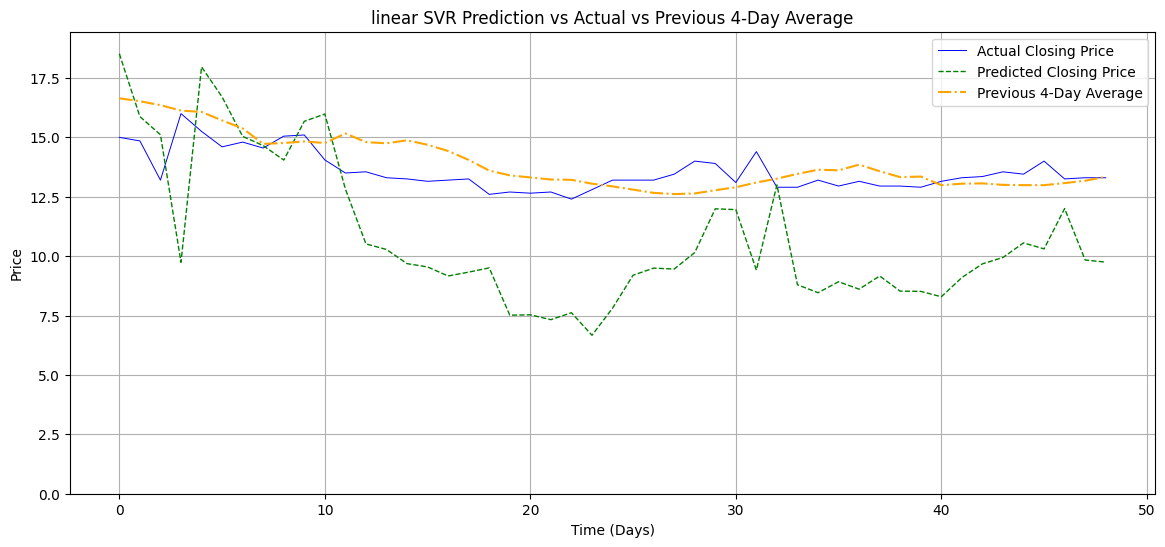

T =  7


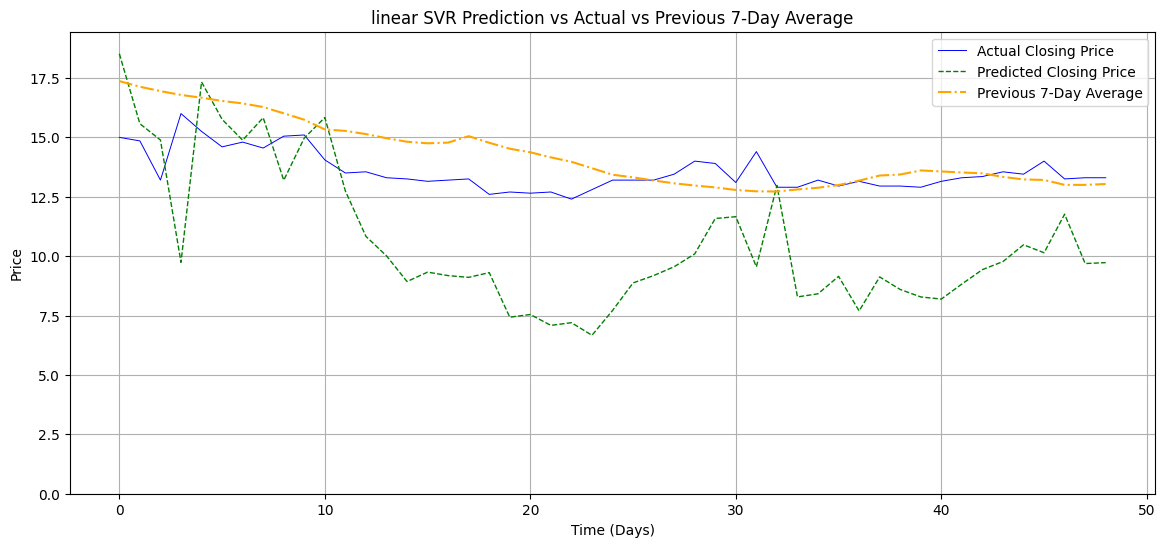

T =  30


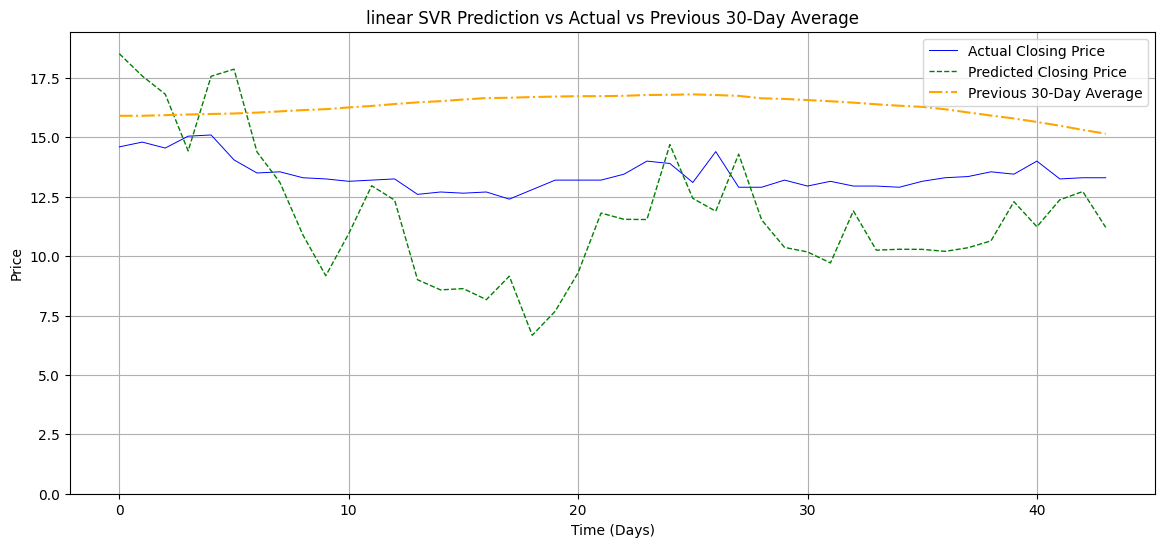

In [42]:
ts = [4,7, 30]
for t in ts:
    X_train, X_test, Y_train, Y_test = get_data(df, t)
    w, b = linear_svr(X_train, Y_train)
    print("T = ", t)
    plot_linear_svr(X_train, Y_train, X_test, Y_test, w, b, t, df_original, scaler)


T =  7 Gamma =  3


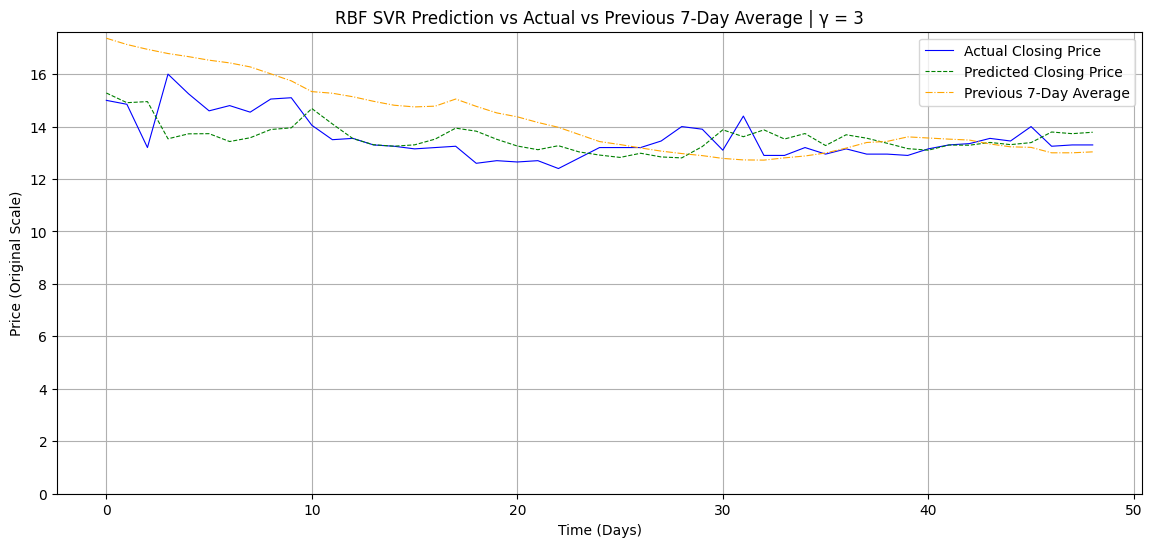

T =  7 Gamma =  2


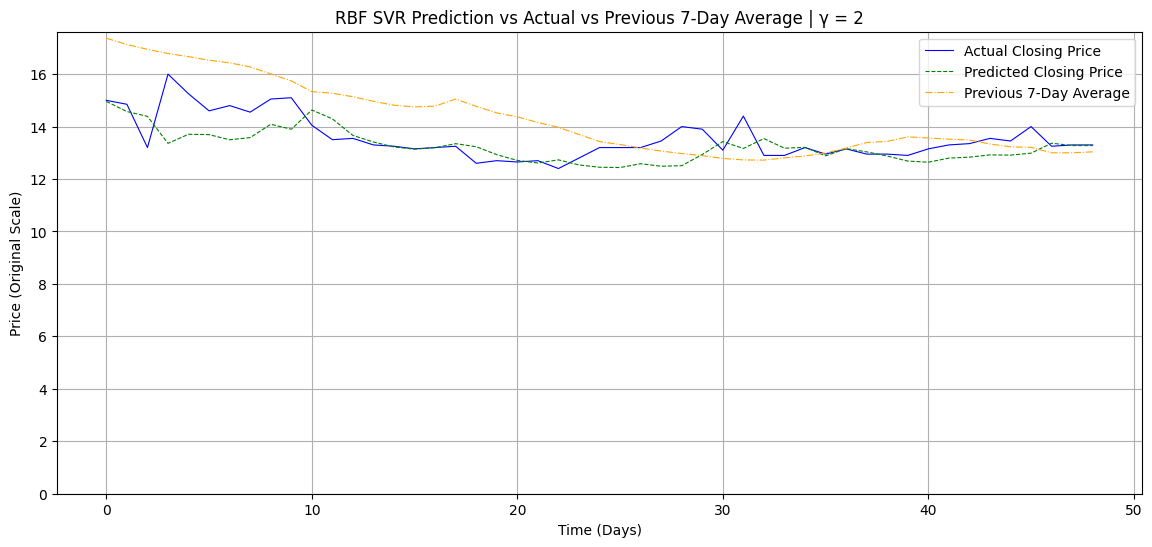

T =  7 Gamma =  1


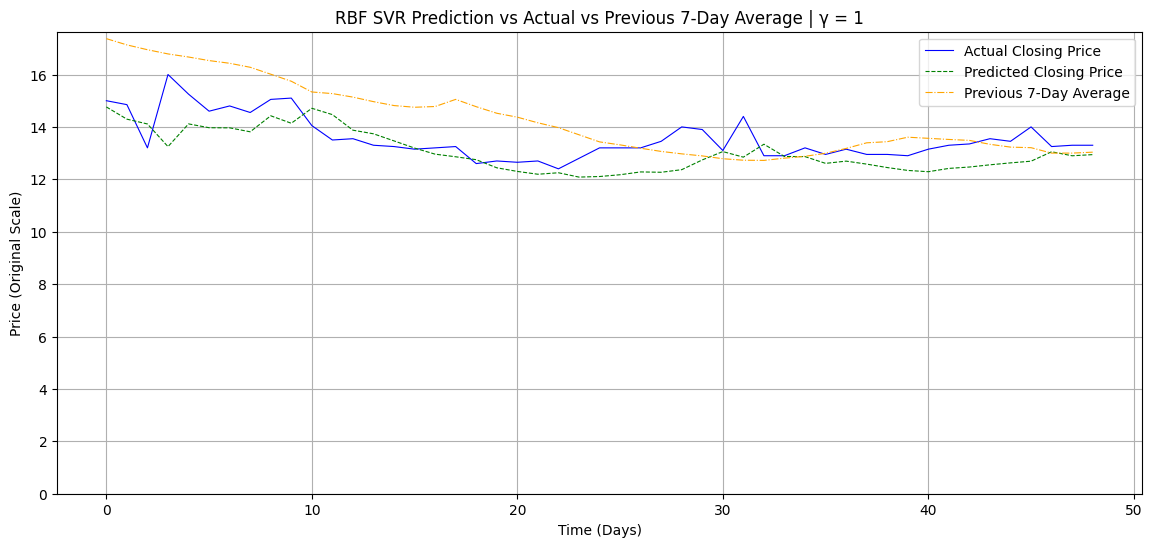

T =  7 Gamma =  0.1


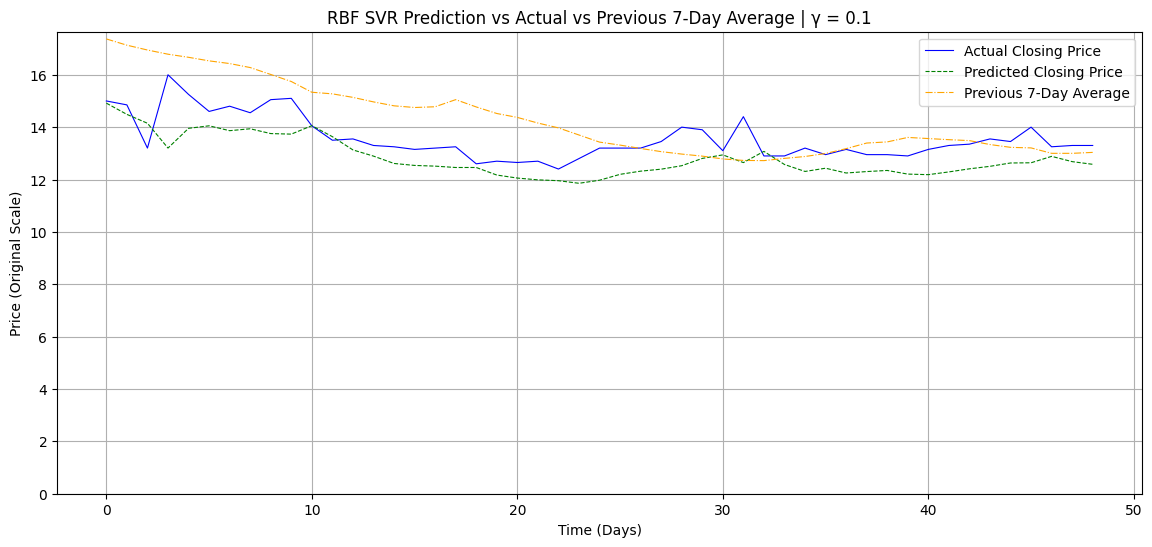

T =  7 Gamma =  0.01


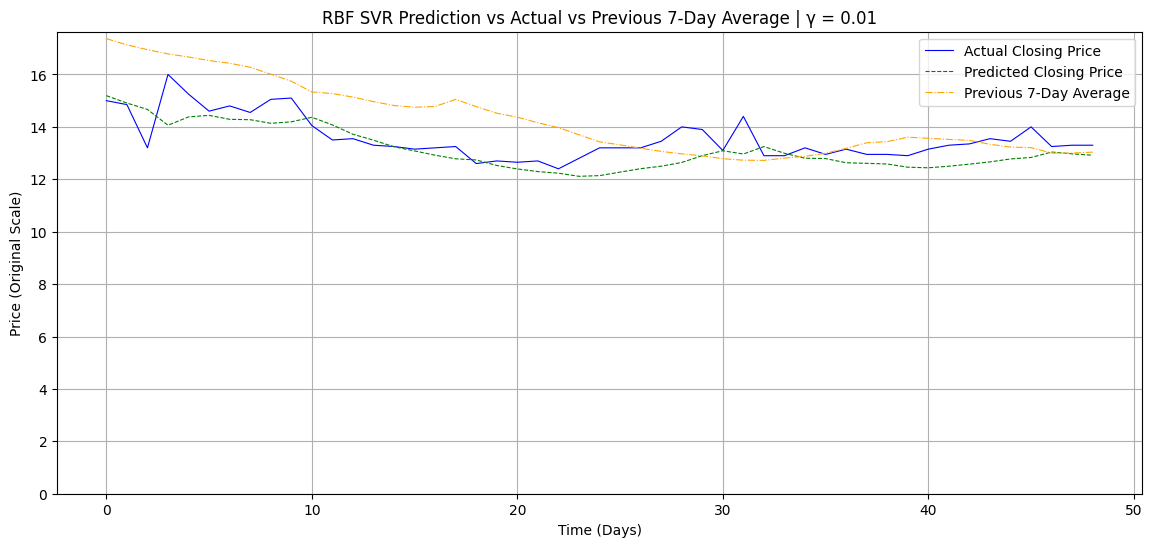

T =  7 Gamma =  0.001


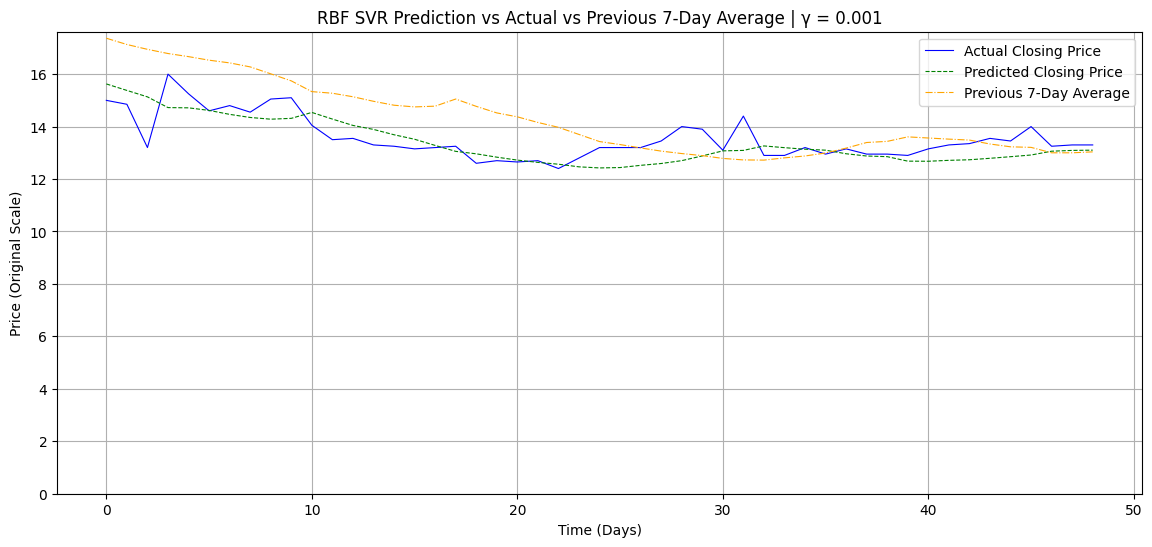

T =  30 Gamma =  3


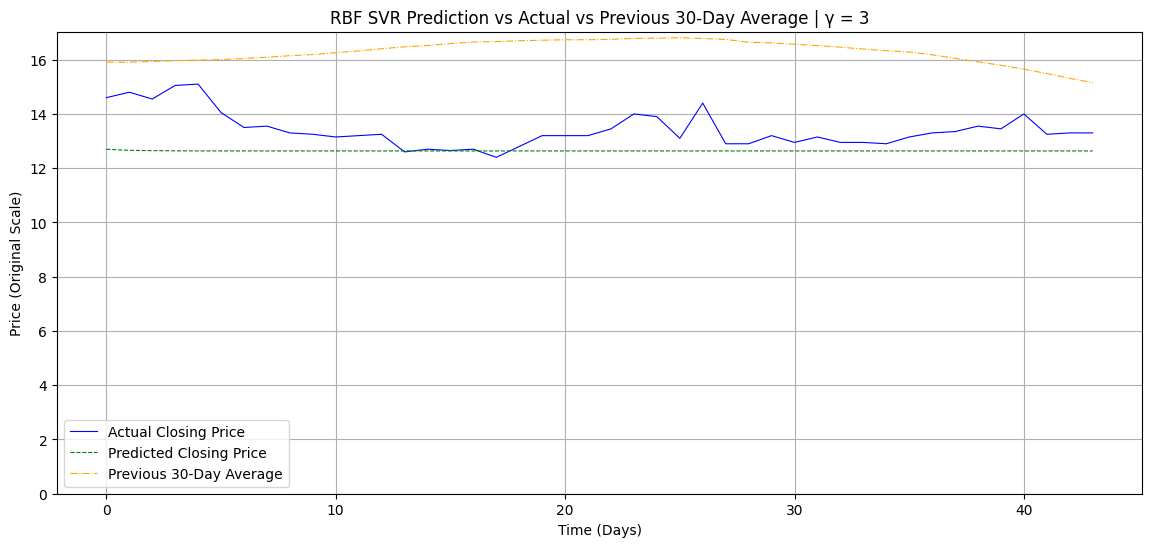

T =  30 Gamma =  2


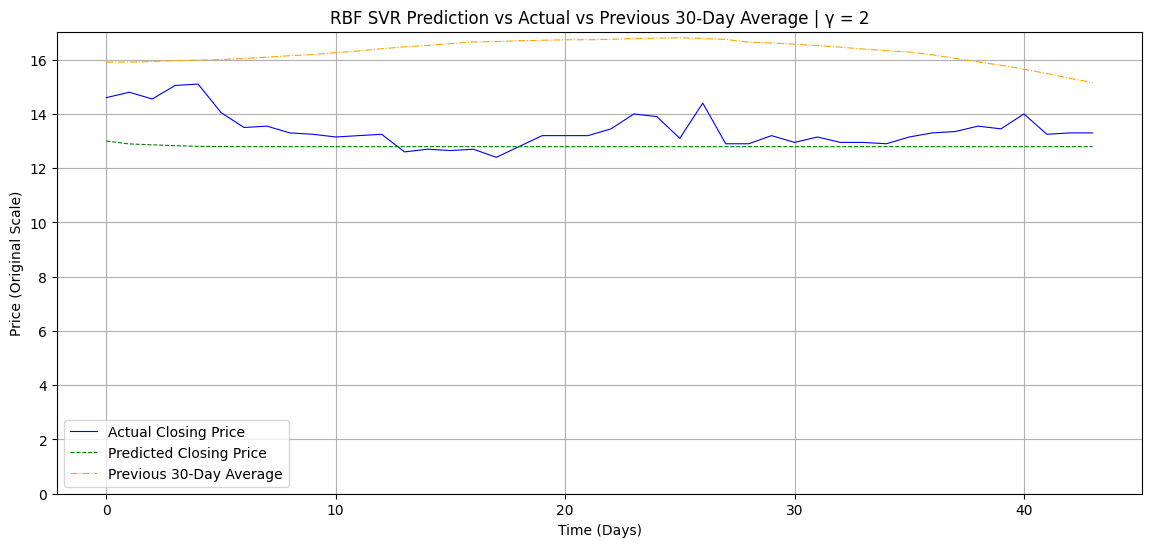

T =  30 Gamma =  1


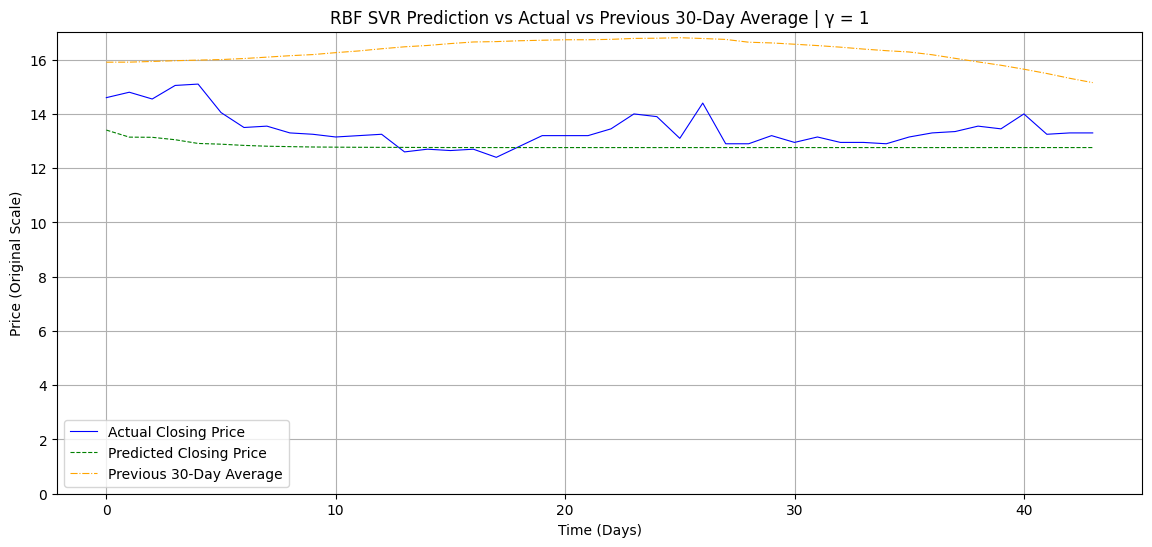

T =  30 Gamma =  0.1


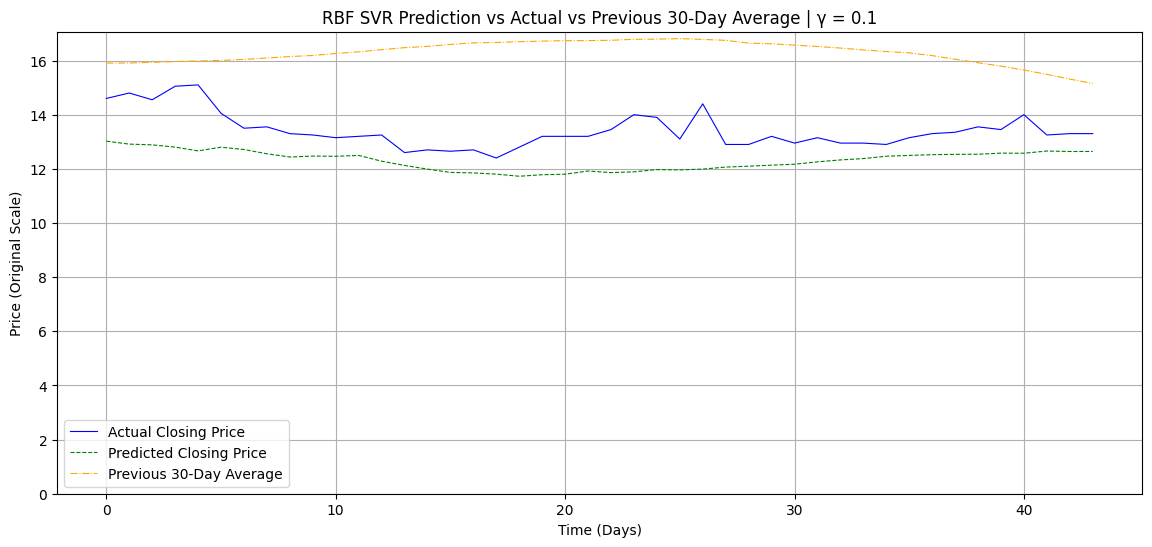

T =  30 Gamma =  0.01


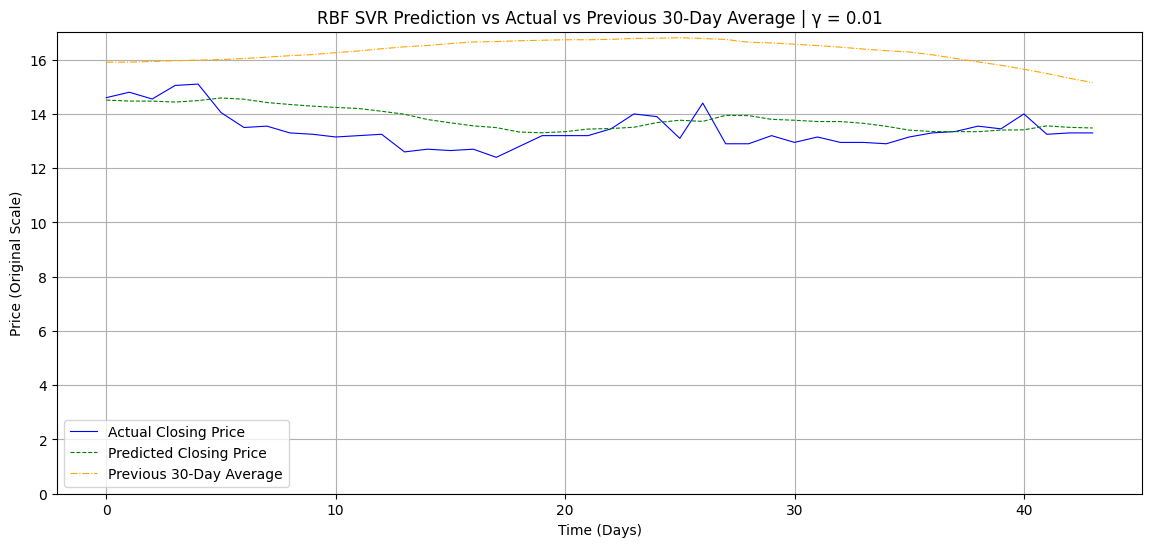

T =  30 Gamma =  0.001


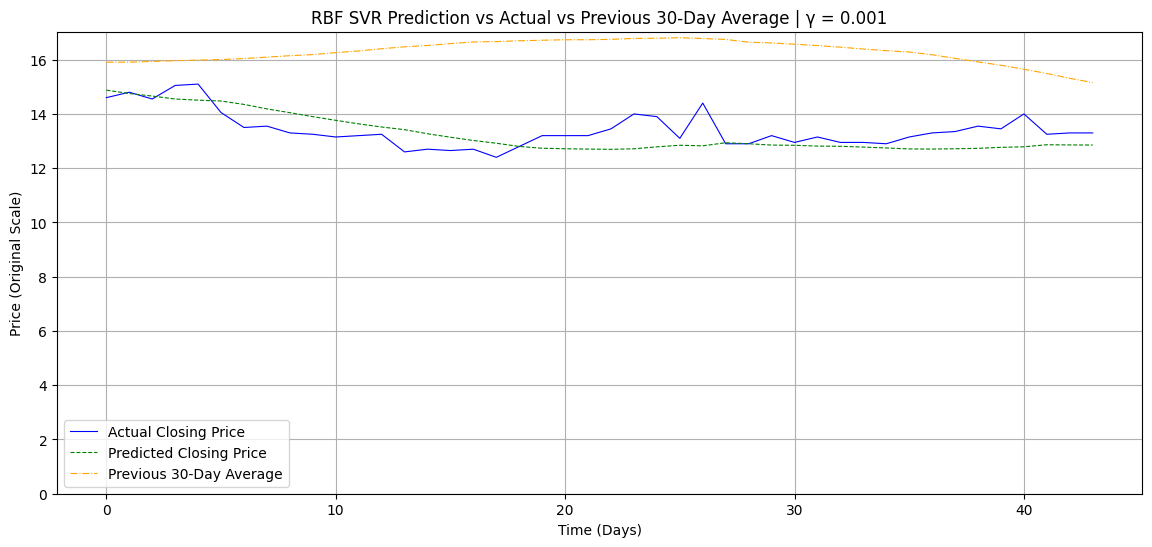

T =  90 Gamma =  3


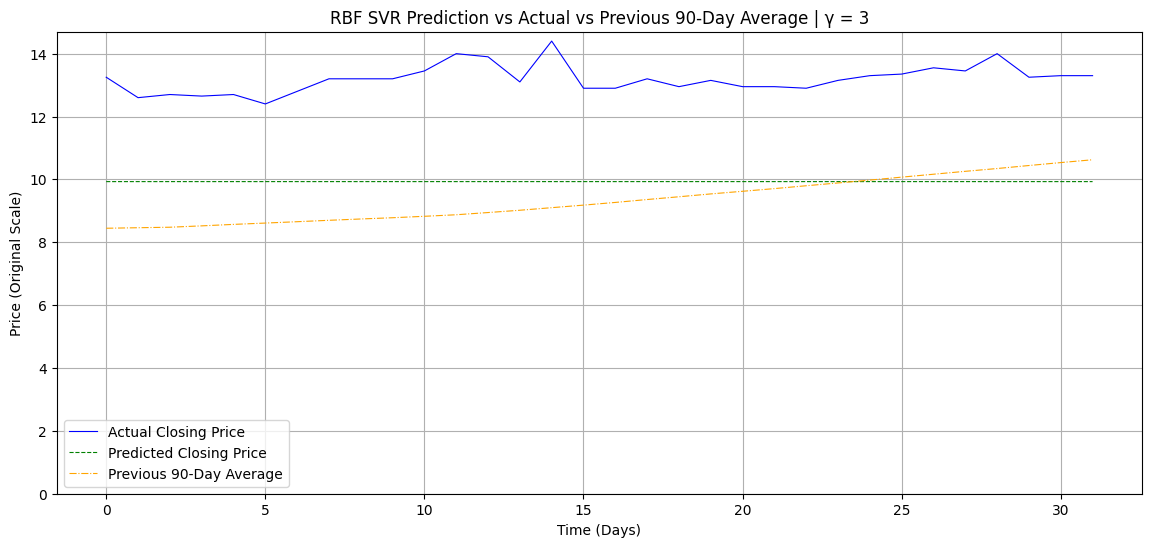

T =  90 Gamma =  2


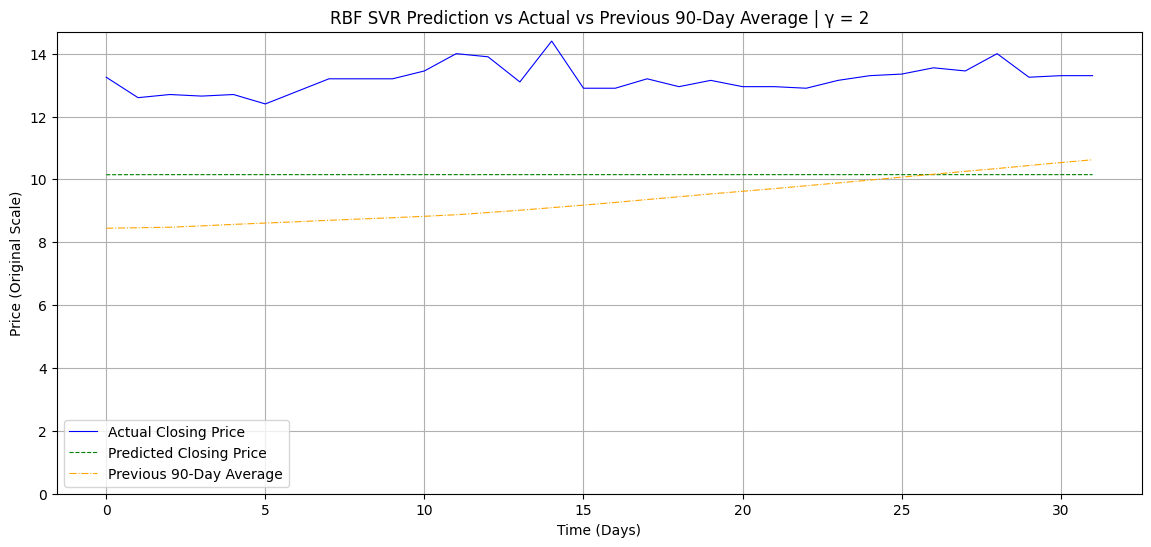

T =  90 Gamma =  1


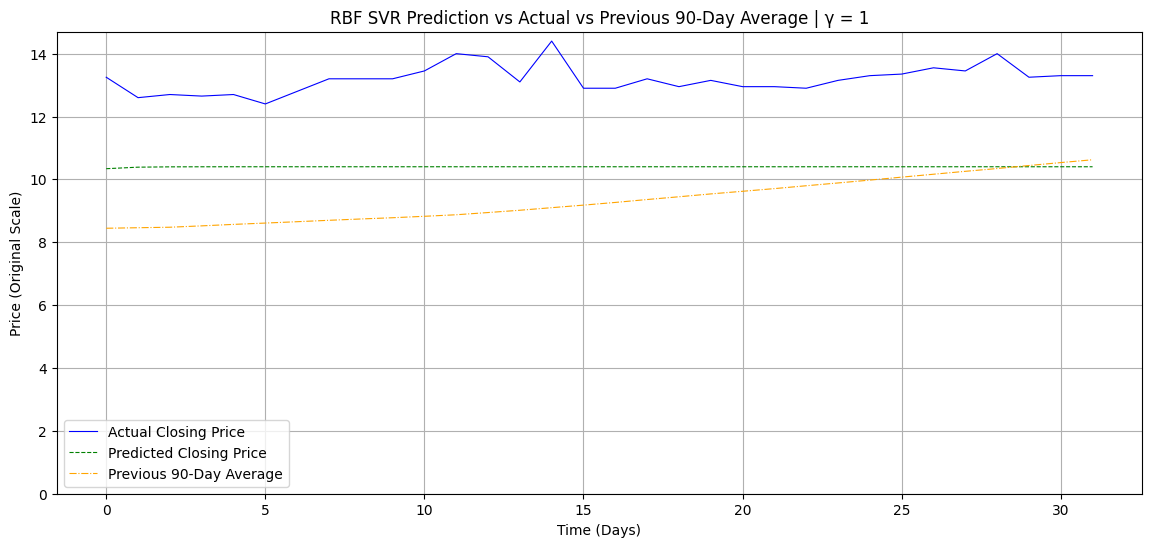

T =  90 Gamma =  0.1


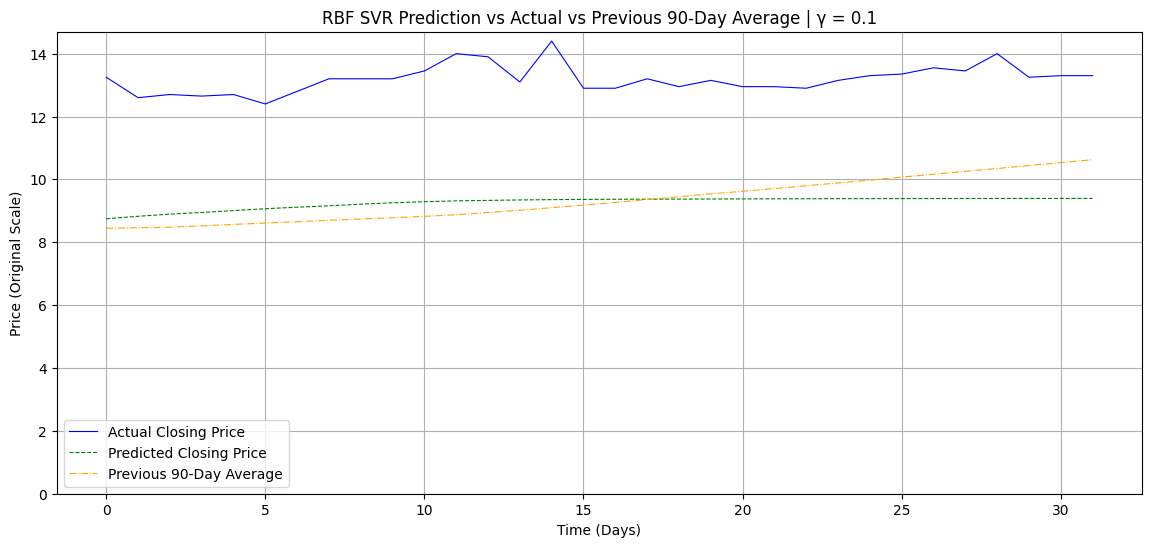

T =  90 Gamma =  0.01


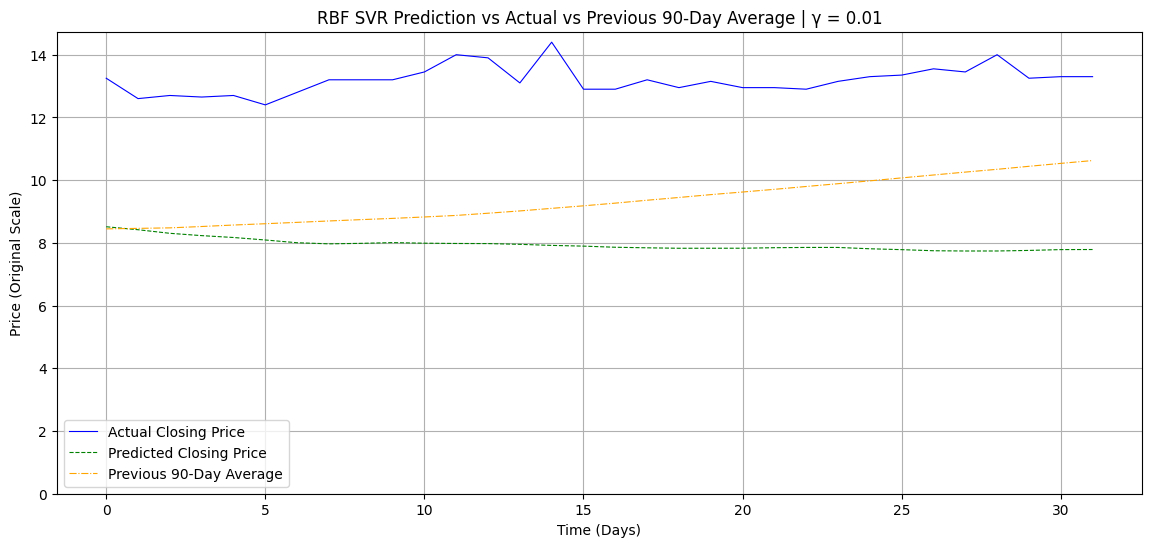

T =  90 Gamma =  0.001


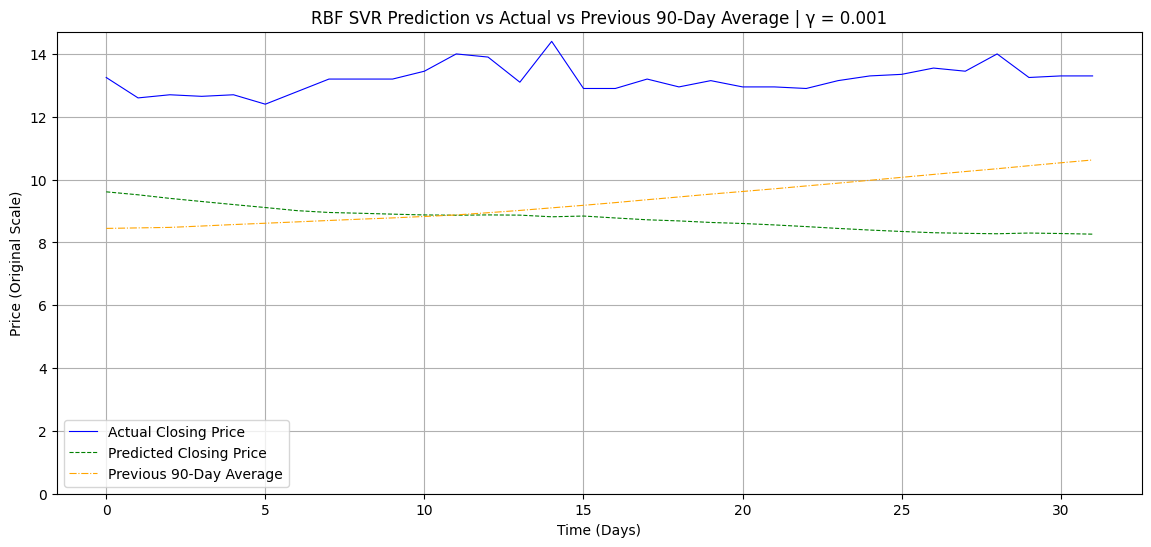

In [41]:
gammas = [3,2,1,0.1, 0.01, 0.001]
ts = [7, 30, 90]
for t in ts:
    for gamma in gammas:
        X_train, X_test, Y_train, Y_test = get_data(df, t)
        alpha, alpha_star, w, b = kernel_svr_dual(X_train, Y_train, gamma)
        print("T = ", t, "Gamma = ", gamma)
        plot_rbf_svr(X_train, Y_train, X_test, Y_test, alpha, alpha_star, b, gamma, t, df_original, scaler)